In [1]:
import re
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('matala2_cosmetics_2019-Nov.csv')
df = pd.DataFrame(data)

C:\Users\tohar\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
#Q1
df['event_time'] = df['event_time'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S UTC'))
df['event_time']= pd.to_datetime(df.event_time)
df.sort_values(["user_id","user_session", "event_time"], inplace=True)#
df['second'] = pd.DatetimeIndex(df.event_time).second+(pd.DatetimeIndex(df.event_time).minute *60)
df['duration_to_next_event'] = df.groupby(["user_session"])['second'].diff().shift(-1).fillna(0)

In [12]:
#Q2
df['day_event_time'] = pd.DatetimeIndex(df.event_time).day
df['days_apart']= df.groupby(["user_id","user_session"])['day_event_time'].diff(periods=-1)
df['days_apart'] = df['days_apart'].apply(lambda x: x*-1)
#ביקשתי שימספר את העמודה עבור פער של 5 ימים או נאל (האחרון  הוא נאל כי אין מול מי לעשות את ההפרש ולאחר מכן מילאתי נתונים חסרים עבור הערך האחרון 
df["funnel_number"] = df.loc[(df.days_apart >=5) | (df.days_apart.isnull() ) ].groupby(["user_id","user_session"])['days_apart'].cumcount()+1
df["funnel_number"] = df.groupby(["user_id","user_session"])["funnel_number"].apply(lambda x: x.fillna(method='bfill'))#מילוי נתונים חסרים



1         1
4         1
5         1
18        1
20        1
         ..
53        1
55        1
56        1
80        1
347434    3
Name: day_event_time, Length: 102, dtype: int64

In [26]:
#Q3
df["index_in_funnel"] = df.loc[(df.days_apart >=5) | (df.days_apart.isnull() ) ].groupby(["user_id"])["funnel_number"].cumcount()+1
df["index_in_funnel"] = df.groupby(["user_id","user_session"])["index_in_funnel"].apply(lambda x: x.fillna(method='bfill'))

,user_id,user_session,funnel_number,index_in_funnel
1,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,1.0,NaN
4,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,1.0,NaN
5,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,1.0,NaN
18,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,1.0,NaN
20,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,1.0,NaN
27,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,1.0,NaN
35,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,1.0,NaN
37,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,1.0,NaN
39,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,1.0,NaN
41,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,1.0,NaN


In [66]:
#Q4 
#עבור כל איבר ברשימה ביקשתי למצוא מספר (אחד או יותר) , נקודה  ואחריו עוד מספר
#וכך במקרה והיה סימן כלשהו הוא לא יכלל בעמודה החדשה
my_list=df["price"].to_list ()
y=re.findall('[0-9]+\.[0-9]+',str(my_list))
df["price"]=y
df["price"]=df["price"].astype(float)

<AxesSubplot:xlabel='event_type', ylabel='count'>

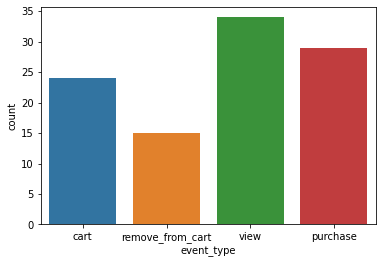

In [69]:
#Q5
sns.countplot(x=df["event_type"])

In [ ]:
#Q6
session_data=df.groupby(["user_id","user_session","funnel_number"])["event_time"].agg(['first','last']).reset_index().copy()#נותן עמודה של ראשון ואחרון
session_data['time_visit'] =session_data['last']-session_data['first']#משך הביקור
session_data["index_in_funnel"]=df.groupby("user_session").mean().reset_index().loc[:,["index_in_funnel"]]
#מספר אירועים כוללשל המשתמש באותו ביקור
session_data["num_event"]=df.groupby("user_session").size().reset_index(name="num_event").loc[:,["num_event"]]
#רק מוצרים שנצפו
session_data['list_of_view']=df.loc[(df.event_type =="view")].groupby('user_session')['product_id'].apply(list).reset_index().copy().loc[:,['product_id']]
#רשימת מוצרים שנוספו לעגלה בביקור 
session_data['list_of_add_to_cart']=df.loc[(df.event_type =="cart")].groupby('user_session')['product_id'].apply(list).reset_index().copy().loc[:,['product_id']]
#כדי למצוא את מספר המוצרים שנרכשו נמצא את מה שהוסר ונוריד אותו ממה שנכנס לעגלה
session_data['remove']=df.loc[(df.event_type =="remove_from_cart")].groupby('user_session')['product_id'].apply(list).reset_index().copy().loc[:,['product_id']]
#מוצרים שנרכשן
session_data["list_of_purchased"]=session_data['list_of_add_to_cart']-session_data['remove']
